In [1]:
import sys

print (sys.version)

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.dpi'] = 200
import seaborn as sns
sns.set_style('white')
from IPython.core.pylabtools import figsize
import tensorflow as tf
import random
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from numpy import float32
from sgt import Sgt
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import sklearn.metrics
import keras
from keras import backend as K
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Masking, RepeatVector, Flatten
from keras.utils import plot_model
from keras.layers import Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers, layers
from keras.optimizers import SGD
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from sklearn.model_selection import GridSearchCV
from keras.layers import Conv2D,MaxPooling2D, Dense, Flatten, Reshape 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import sklearn.metrics
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import os
import json,pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import rdkit
import modlamp
import mdtraj

Using TensorFlow backend.


In [3]:
train_fold = json.load(open("C:/Users/bmbungamputu/Downloads/Davis/train_fold_setting1.txt"))
#train_fold = [ee for e in train_fold for ee in e ]
valid_fold = json.load(open("C:/Users/bmbungamputu/Downloads/Davis/test_fold_setting1.txt"))
ligands = json.load(open("C:/Users/bmbungamputu/Downloads/Davis/ligands_can.txt"), object_pairs_hook=OrderedDict)
proteins = json.load(open("C:/Users/bmbungamputu/Downloads/Davis/proteins.txt"), object_pairs_hook=OrderedDict)
affinity = pickle.load(open("C:/Users/bmbungamputu/Downloads/Davis/Y","rb"), encoding='latin1')

In [3]:
all_prots = []
datasets = ['Kiba','Davis']
for dataset in datasets:
    fpath = 'C:/Users/bmbungamputu/Downloads/' + dataset + '/'
    train_fold = json.load(open(fpath + "train_fold_setting1.txt"))
    train_fold = [ee for e in train_fold for ee in e ]
    valid_fold = json.load(open(fpath + "test_fold_setting1.txt"))
    ligands = json.load(open(fpath + "ligands_can.txt"), object_pairs_hook=OrderedDict)
    proteins = json.load(open(fpath + "proteins.txt"), object_pairs_hook=OrderedDict)
    affinity = pickle.load(open(fpath + "Y","rb"), encoding='latin1')
    drugs = []
    prots = []
    for d in ligands.keys():
        lg = Chem.MolToSmiles(Chem.MolFromSmiles(ligands[d]),isomericSmiles=True)
        drugs.append(lg)
    for t in proteins.keys():
        prots.append(proteins[t])
    if dataset == 'Davis':
        affinity = [-np.log10(y/1e9) for y in affinity]
    affinity = np.asarray(affinity)
    opts = ['train','test']
    for opt in opts:
        rows, cols = np.where(np.isnan(affinity)==False)  
        if opt=='train':
            rows,cols = rows[train_fold], cols[train_fold]
        elif opt=='test':
            rows,cols = rows[valid_fold], cols[valid_fold]
        with open('C:/Users/bmbungamputu/Downloads/' + dataset + '_' + opt + '.csv', 'w') as f:
            f.write('compound_iso_smiles,target_sequence,affinity\n')
            for pair_ind in range(len(rows)):
                ls = []
                ls += [ drugs[rows[pair_ind]]  ]
                ls += [ prots[cols[pair_ind]]  ]
                ls += [ affinity[rows[pair_ind],cols[pair_ind]]  ]
                f.write(','.join(map(str,ls)) + '\n')       
    print('\ndataset:', dataset)
    print('train_fold:', len(train_fold))
    print('test_fold:', len(valid_fold))
    print('len(set(drugs)),len(set(prots)):', len(set(drugs)),len(set(prots)))
    all_prots += list(set(prots))


dataset: Kiba
train_fold: 98545
test_fold: 19709
len(set(drugs)),len(set(prots)): 2068 229

dataset: Davis
train_fold: 25046
test_fold: 5010
len(set(drugs)),len(set(prots)): 68 379


In [4]:
for dt_name in ['Kiba']:
    opts = ['train']
    for opt in opts:
        df = pd.read_csv('C:/Users/bmbungamputu/Downloads/' + dt_name + '_' + opt + '.csv')

In [5]:
df.shape

(98545, 3)

In [6]:
df.head(2)

,compound_iso_smiles,target_sequence,affinity
0,O=C1c2c(c3c4ccc(O)cc4n(C4OC(CO)C(O)C(O)C4O)c3c...,MSANNSPPSAQKSVLPTAIPAVLPAASPCSSPKTGLSARLSNGSFS...,9.79897
1,N#Cc1ccc(NC(=O)Nc2ccnc3cc(C(F)(F)F)ccc23)nc1,MLGAVEGPRWKQAEDIRDIYDFRDVLGTGAFSEVILAEDKRTQKLV...,11.40000


C:\Users\bmbungamputu\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


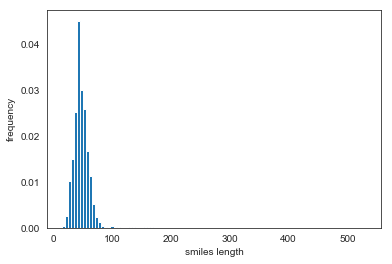

In [7]:
df_seqs = df.compound_iso_smiles.values
lengths = [len(s) for s in df_seqs]
plt.hist(lengths, bins=100, normed=True)
plt.xlabel('smiles length')
plt.ylabel('frequency')
plt.show()

Text(0, 0.5, 'probability')

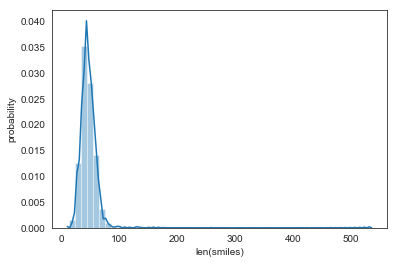

In [8]:
df['len'] = [len(i) for i in df['compound_iso_smiles']]
df_smiles_lens = [len(i) for i in df['compound_iso_smiles']]
sns.distplot(df_smiles_lens)
plt.xlabel('len(smiles)')
plt.ylabel('probability')

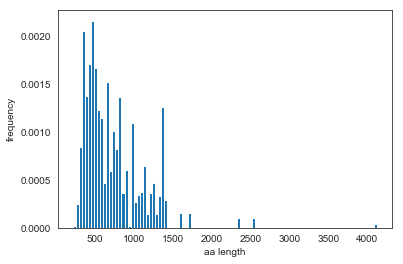

In [9]:
df_seqs_aa = df.target_sequence.values
lengths = [len(s) for s in df_seqs_aa]
plt.hist(lengths, bins=100, normed=True)
plt.xlabel('aa length')
plt.ylabel('frequency')
plt.show()

Text(0, 0.5, 'probability')

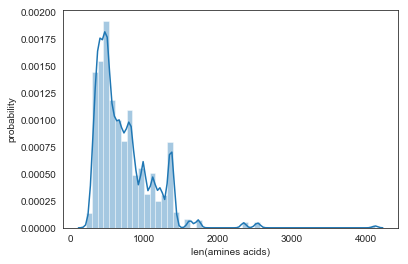

In [10]:
df['len'] = [len(i) for i in df['target_sequence']]
df_aa_lens = [len(i) for i in df['target_sequence']]
sns.distplot(df_aa_lens)
plt.xlabel('len(amines acids)')
plt.ylabel('probability')

In [11]:
for dt_name in ['Kiba']:
    opts = ['test']
    for opt in opts:
        df1 = pd.read_csv('C:/Users/bmbungamputu/Downloads/' + dt_name + '_' + opt + '.csv')

In [12]:
df1.shape

(19709, 3)

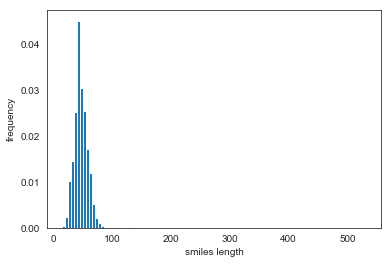

In [13]:
df1_seqs = df1.compound_iso_smiles.values
lengths = [len(s) for s in df1_seqs]
plt.hist(lengths, bins=100, normed=True)
plt.xlabel('smiles length')
plt.ylabel('frequency')
plt.show()

In [14]:
for dt_name in ['Davis']:
    opts = ['train']
    for opt in opts:
        df2 = pd.read_csv('C:/Users/bmbungamputu/Downloads/' + dt_name + '_' + opt + '.csv')

In [15]:
df2.shape

(25046, 3)

In [16]:
for dt_name in ['Davis']:
    opts = ['test']
    for opt in opts:
        df3 = pd.read_csv('C:/Users/bmbungamputu/Downloads/' + dt_name + '_' + opt + '.csv')

In [17]:
df3.shape

(5010, 3)

In [18]:
#X = df2.compound_iso_smiles
#def split(word): 
    #return [char for char in word]
#drugs_split = [split(x) for x in X]
#print(drugs_split[2])

In [19]:
#X = df3.compound_iso_smiles
#def split(word): 
    #return [char for char in word]
#drugs_split1 = [split(x) for x in X]
#print(drugs_split1[2])

In [20]:
#sgt = Sgt(kappa = 10, lengthsensitive = False)
#smi_df2 = sgt.fit_transform(corpus=drugs_split)

In [21]:
#sgt = Sgt(kappa = 10, lengthsensitive = False)
#smi_df3 = sgt.fit_transform(corpus=drugs_split1)

In [22]:
# maximum length of sequence, everything afterwards is discarded!
max_length1 = 85
embedding_dim = 128

#create and fit tokenizer
tokenizer1 = Tokenizer(char_level=True)
tokenizer1.fit_on_texts(df2.compound_iso_smiles)
#represent input data as word rank number sequences
df2_smi = tokenizer1.texts_to_sequences(df2.compound_iso_smiles)
X_smi_df2 = sequence.pad_sequences(df2_smi, maxlen=max_length1, padding='post',value=0.0)

In [23]:
# maximum length of sequence, everything afterwards is discarded!
max_length1 = 85
embedding_dim = 128

#create and fit tokenizer
tokenizer1 = Tokenizer(char_level=True)
tokenizer1.fit_on_texts(df3.compound_iso_smiles)
#represent input data as word rank number sequences
df3_smi = tokenizer1.texts_to_sequences(df3.compound_iso_smiles)
X_smi_df3 = sequence.pad_sequences(df3_smi, maxlen=max_length1, padding='post',value=0.0)

In [24]:
#X = df2.target_sequence
#def split(word): 
    #return [char for char in word]
#prots_split = [split(x) for x in X]
#print(prots_split[2])

In [25]:
#X = df3.target_sequence
#def split(word): 
    #return [char for char in word]
#prots_split1 = [split(x) for x in X]
#print(prots_split1[2])

In [26]:
#sgt = Sgt(kappa = 10, lengthsensitive = False)
#seq_df2 = sgt.fit_transform(corpus=prots_split)

In [27]:
#sgt = Sgt(kappa = 10, lengthsensitive = False)
#seq_df3 = sgt.fit_transform(corpus=prots_split1)

In [28]:
# maximum length of sequence, everything afterwards is discarded!
max_length2 = 1200
embedding_dim = 128

#create and fit tokenizer
tokenizer1 = Tokenizer(char_level=True)
tokenizer1.fit_on_texts(df2.target_sequence)
#represent input data as word rank number sequences
df2_prots = tokenizer1.texts_to_sequences(df2.target_sequence)
X_prots_df2 = sequence.pad_sequences(df2_prots, maxlen=max_length2, padding='post',value=0.0)

In [29]:
# maximum length of sequence, everything afterwards is discarded!
max_length2 = 1200
embedding_dim = 128

#create and fit tokenizer
tokenizer1 = Tokenizer(char_level=True)
tokenizer1.fit_on_texts(df3.target_sequence)
#represent input data as word rank number sequences
df3_prots = tokenizer1.texts_to_sequences(df3.target_sequence)
X_prots_df3 = sequence.pad_sequences(df3_prots, maxlen=max_length2, padding='post',value=0.0)

In [30]:
X_prots_df3

array([[18,  5,  5, ...,  0,  0,  0],
       [18,  9,  4, ...,  0,  0,  0],
       [18,  5,  5, ...,  0,  0,  0],
       ...,
       [ 6,  1, 16, ..., 11,  8,  8],
       [18,  2,  9, ...,  0,  0,  0],
       [18,  2,  8, ...,  0,  0,  0]])

In [31]:
X_prots_df3.shape

(5010, 1200)

In [32]:
#df = pd.read_csv('C:/Users/bmbungamputu/Downloads/' + dataset + '_train.csv')
train_drugs, train_prots,  train_Y = list(df2['compound_iso_smiles']),list(df2['target_sequence']),list(df2['affinity'])
XT = X_prots_df2
XD = X_smi_df2
train_drugs, train_prots,  train_Y = np.asarray(X_smi_df2), np.asarray(X_prots_df2), np.asarray(train_Y)

In [33]:
train_drugs.shape

(25046, 85)

In [34]:
test_drugs, test_prots,  test_Y = list(df3['compound_iso_smiles']),list(df3['target_sequence']),list(df3['affinity'])
XT = X_prots_df3
XD = X_smi_df3
test_drugs, test_prots,  test_Y = np.asarray(XD), np.asarray(XT), np.asarray(test_Y)


In [35]:
test_drugs.shape

(5010, 85)

In [36]:
test_prots.shape

(5010, 1200)

In [37]:
CHARPROTSET = { "A": 1, "C": 2, "B": 3, "E": 4, "D": 5, "G": 6, 
				"F": 7, "I": 8, "H": 9, "K": 10, "M": 11, "L": 12, 
				"O": 13, "N": 14, "Q": 15, "P": 16, "S": 17, "R": 18, 
				"U": 19, "T": 20, "W": 21, 
				"V": 22, "Y": 23, "X": 24, 
				"Z": 25 }

CHARPROTLEN = 25

In [38]:
CHARISOSMISET = {"#": 29, "%": 30, ")": 31, "(": 1, "+": 32, "-": 33, "/": 34, ".": 2, 
				"1": 35, "0": 3, "3": 36, "2": 4, "5": 37, "4": 5, "7": 38, "6": 6, 
				"9": 39, "8": 7, "=": 40, "A": 41, "@": 8, "C": 42, "B": 9, "E": 43, 
				"D": 10, "G": 44, "F": 11, "I": 45, "H": 12, "K": 46, "M": 47, "L": 13, 
				"O": 48, "N": 14, "P": 15, "S": 49, "R": 16, "U": 50, "T": 17, "W": 51, 
				"V": 18, "Y": 52, "[": 53, "Z": 19, "]": 54, "\\": 20, "a": 55, "c": 56, 
				"b": 21, "e": 57, "d": 22, "g": 58, "f": 23, "i": 59, "h": 24, "m": 60, 
				"l": 25, "o": 61, "n": 26, "s": 62, "r": 27, "u": 63, "t": 28, "y": 64}

CHARISOSMILEN = 64

In [71]:
max_smi_len = max_length1
max_seq_len = max_length2
charsmiset_size = CHARISOSMILEN
charseqset_size = CHARPROTLEN
XDinput = Input(shape=(max_smi_len,), dtype='int32') ### Buralar flagdan gelmeliii
XTinput = Input(shape=(max_seq_len,), dtype='int32')

     
smiles = Embedding(input_dim=charsmiset_size+1, output_dim=128, input_length=max_smi_len)(XDinput) 
smiles_1 = Conv1D(filters=32, kernel_size=4,  activation='relu', padding='valid',  strides=1)(smiles)
smiles_2 = Conv1D(filters=64, kernel_size=6,  activation='relu', padding='valid',  strides=1)(smiles_1)
smiles_3 = Conv1D(filters=96, kernel_size=8,  activation='relu', padding='valid',  strides=1)(smiles_2)
smiles_4 = BatchNormalization()(smiles_3)
smiles_5 = GlobalMaxPooling1D()(smiles_4)


protein = Embedding(input_dim=charseqset_size+1, output_dim=128, input_length=max_seq_len)(XTinput)
protein_1 = Conv1D(filters=32, kernel_size=4,  activation='relu', padding='valid',  strides=1)(protein)
protein_2 = Conv1D(filters=64, kernel_size=8,  activation='relu', padding='valid',  strides=1)(protein_1)
protein_3 = Conv1D(filters=96, kernel_size=12,  activation='relu', padding='valid',  strides=1)(protein_2)
protein_4 = BatchNormalization() (protein_3)
protein_5 = GlobalMaxPooling1D()(protein_4)

#merge.Add()([encode_smiles, encode_protein])

interaction = keras.layers.concatenate([smiles_5, protein_5], axis=-1) 

# Fully connected
Bn = BatchNormalization()(interaction)
FC1 = Dense(1024, activation='relu')(Bn)
FC2 = Dropout(0.1)(FC1)
FC3 = Dense(1024, activation='relu')(FC2)
FC4 = Dropout(0.1)(FC3)
FC5 = Dense(512, activation='relu')(FC4)


predictions = Dense(1, kernel_initializer='normal')(FC5) 

interactionModel = Model(inputs=[XDinput, XTinput], outputs=[predictions])

interactionModel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae']) 
print(interactionModel.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 85)           0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 1200)         0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 85, 128)      8320        input_13[0][0]                   
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1200, 128)    3328        input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_37 

In [72]:
# Set callback functions to early stop training and save the best model so far
#callbacks = [EarlyStopping(monitor='val_loss', patience=15)]
history = interactionModel.fit(([np.array(train_drugs),np.array(train_prots) ]), np.array(train_Y), validation_data=(([np.array(test_drugs),np.array(test_prots) ]), np.array(test_Y)), batch_size=256, epochs=100,  
shuffle=False )

Train on 25046 samples, validate on 5010 samples
Epoch 1/100
25046/25046 [==============================] - 795s 32ms/step - loss: 1.4755 - mean_absolute_error: 0.7891 - val_loss: 7.9731 - val_mean_absolute_error: 2.6219
Epoch 2/100
25046/25046 [==============================] - 807s 32ms/step - loss: 0.5025 - mean_absolute_error: 0.5008 - val_loss: 3.5610 - val_mean_absolute_error: 1.7313
Epoch 3/100
25046/25046 [==============================] - 867s 35ms/step - loss: 0.4245 - mean_absolute_error: 0.4611 - val_loss: 1.6864 - val_mean_absolute_error: 1.1471
Epoch 4/100
25046/25046 [==============================] - 881s 35ms/step - loss: 0.3748 - mean_absolute_error: 0.4371 - val_loss: 1.1345 - val_mean_absolute_error: 0.8677
Epoch 5/100
25046/25046 [==============================] - 916s 37ms/step - loss: 0.3456 - mean_absolute_error: 0.4204 - val_loss: 1.0432 - val_mean_absolute_error: 0.8404
Epoch 6/100
25046/25046 [==============================] - 941s 38ms/step - loss: 0.3134 - 

25046/25046 [==============================] - 808s 32ms/step - loss: 0.1060 - mean_absolute_error: 0.2236 - val_loss: 0.9481 - val_mean_absolute_error: 0.7359
Epoch 96/100
25046/25046 [==============================] - 819s 33ms/step - loss: 0.1043 - mean_absolute_error: 0.2207 - val_loss: 1.3648 - val_mean_absolute_error: 0.9599
Epoch 97/100
25046/25046 [==============================] - 815s 33ms/step - loss: 0.0936 - mean_absolute_error: 0.2055 - val_loss: 1.3746 - val_mean_absolute_error: 0.9773
Epoch 98/100
25046/25046 [==============================] - 860s 34ms/step - loss: 0.0874 - mean_absolute_error: 0.1969 - val_loss: 1.3787 - val_mean_absolute_error: 0.9828
Epoch 99/100
25046/25046 [==============================] - 866s 35ms/step - loss: 0.0836 - mean_absolute_error: 0.1931 - val_loss: 1.2401 - val_mean_absolute_error: 0.9195
Epoch 100/100
25046/25046 [==============================] - 818s 33ms/step - loss: 0.0850 - mean_absolute_error: 0.1927 - val_loss: 1.2824 - val_me

In [74]:
test_score = interactionModel.evaluate(([np.array(test_drugs),np.array(test_prots) ]), np.array(test_Y), verbose=0)

In [75]:
test_score

[1.2823988340571968, 0.9286961679211158]

In [88]:
test_score_kiba =interactionModel.evaluate(([np.array(te_drugs),np.array(te_prots) ]), np.array(te_Y), verbose=0)

In [89]:
test_score_kiba

[63.92475322228091, 7.938831907047142]

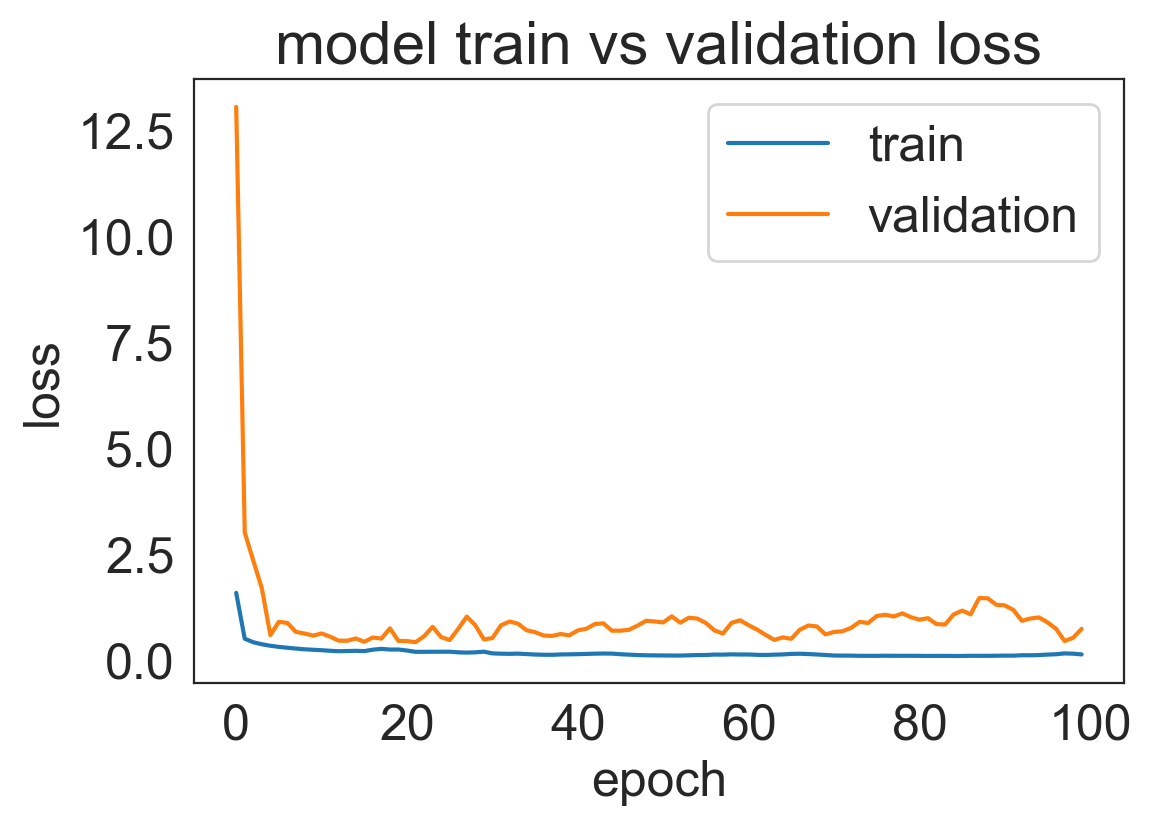

In [72]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

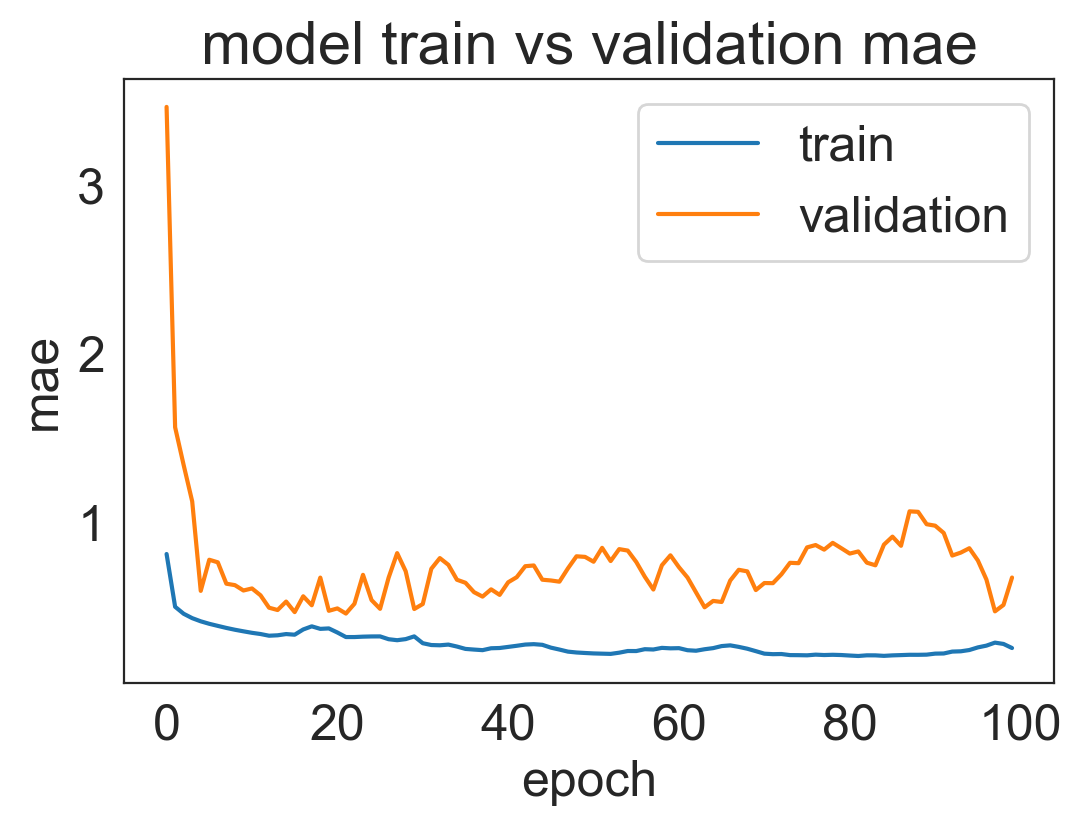

In [73]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model train vs validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [77]:
predicted_test_Y = interactionModel.predict([np.array(test_drugs), np.array(test_prots) ])

In [90]:
predicted_te_Y = interactionModel.predict([np.array(te_drugs), np.array(te_prots) ])

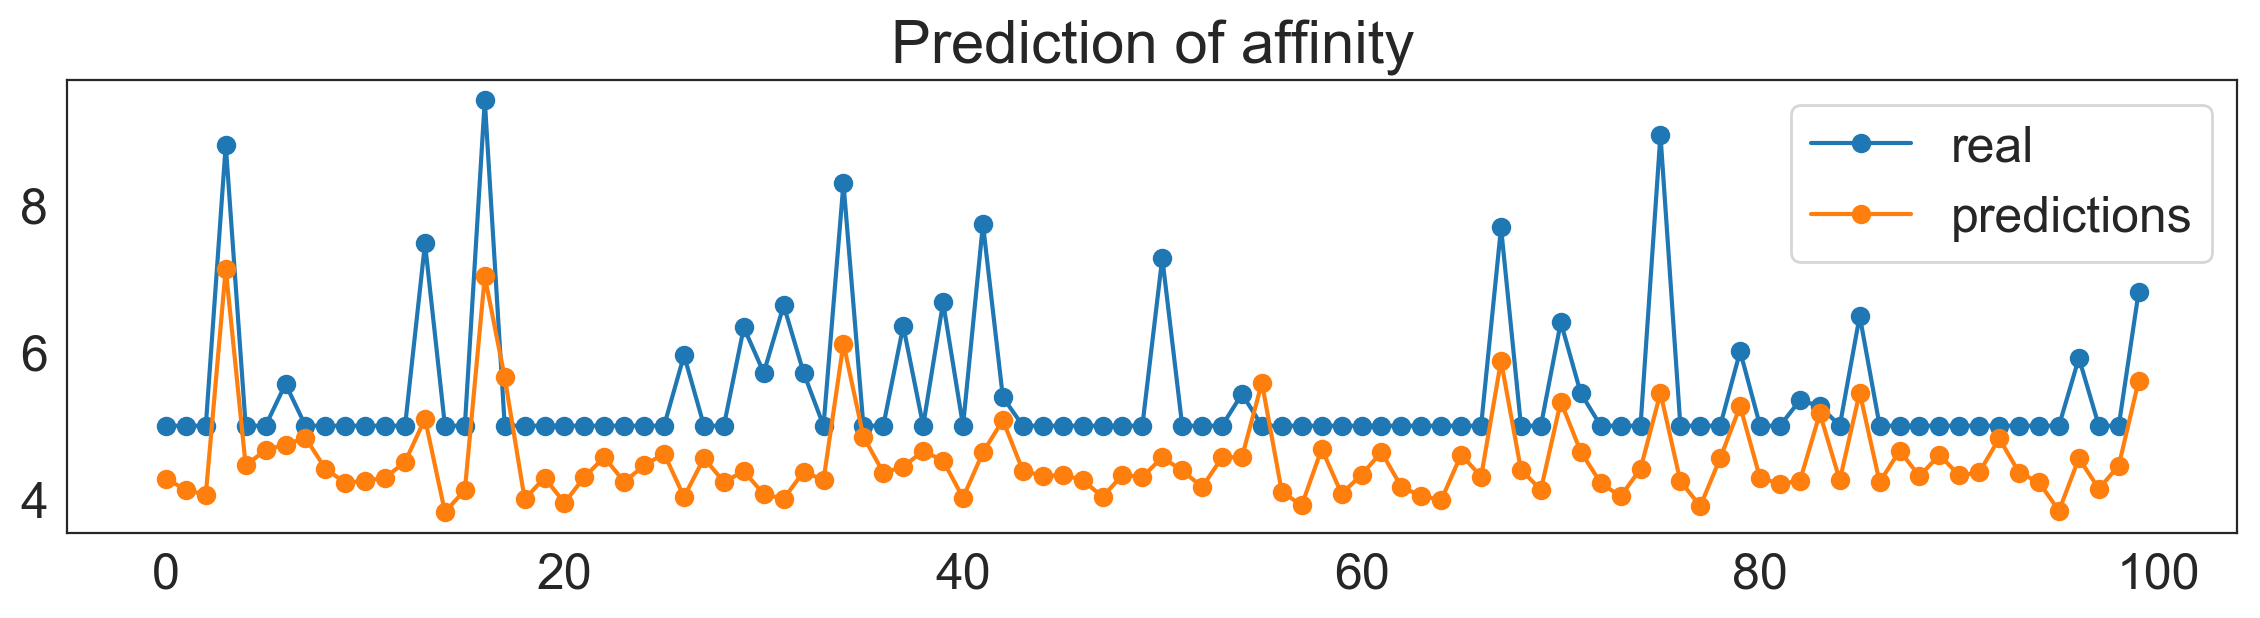

In [92]:
plt.figure(figsize=(14,3))
plt.plot(range(100), test_Y[:100], '-o', label = 'real data')
plt.plot(range(100), predicted_test_Y[:100], '-o', label = 'predictions')
plt.title('Prediction of affinity')
plt.legend(['real', 'predictions'], loc='upper right')
plt.show();

In [ ]:
plt.figure(figsize=(14,2))
plt.scatter(range(100), test_Y[:100], s=100)
plt.scatter(range(100), predicted_test_Y[:100], s=25);

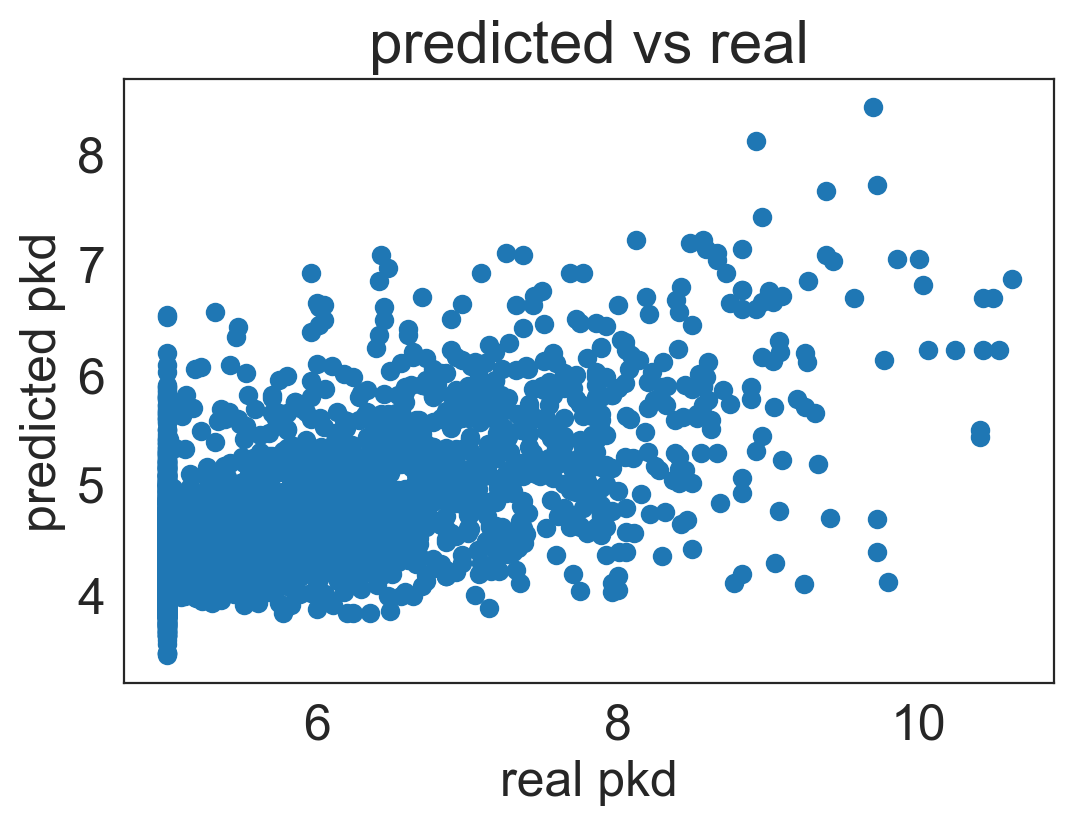

In [93]:
plt.scatter(test_Y, predicted_test_Y)
plt.title('predicted vs real')
plt.ylabel('predicted pkd')
plt.xlabel('real pkd')
plt.show()

In [94]:
 predicted_test_Y[10]

array([4.249982], dtype=float32)

In [95]:
test_Y[10] 

5.0

In [96]:
0.66/10.8

0.06111111111111111

In [39]:
# maximum length of sequence, everything afterwards is discarded!
max_length_2 = 1000
embedding_dim = 128

#create and fit tokenizer
tokenizer_k = Tokenizer(char_level=True)
tokenizer_k.fit_on_texts(df.target_sequence)
#represent input data as word rank number sequences
df_prots = tokenizer_k.texts_to_sequences(df.target_sequence)
prots_k_tr = sequence.pad_sequences(df_prots, maxlen=max_length_2, padding='post',value=0.0)

In [40]:
# maximum length of sequence, everything afterwards is discarded!
max_length_2 = 1000
embedding_dim = 128

#create and fit tokenizer
tokenizer_k = Tokenizer(char_level=True)
tokenizer_k.fit_on_texts(df1.target_sequence)
#represent input data as word rank number sequences
df1_prots = tokenizer_k.texts_to_sequences(df1.target_sequence)
prots_k_te = sequence.pad_sequences(df1_prots, maxlen=max_length_2, padding='post',value=0.0)

In [41]:
# maximum length of sequence, everything afterwards is discarded!
max_length_1 = 100
embedding_dim = 128

#create and fit tokenizer
tokenizer_k = Tokenizer(char_level=True)
tokenizer_k.fit_on_texts(df.compound_iso_smiles)
#represent input data as word rank number sequences
df_drugs = tokenizer_k.texts_to_sequences(df.compound_iso_smiles)
drugs_k_tr = sequence.pad_sequences(df_drugs, maxlen=max_length_1, padding='post',value=0.0)

In [42]:
# maximum length of sequence, everything afterwards is discarded!
max_length_1 = 100
embedding_dim = 128

#create and fit tokenizer
tokenizer_k = Tokenizer(char_level=True)
tokenizer_k.fit_on_texts(df1.compound_iso_smiles)
#represent input data as word rank number sequences
df_drugs1 = tokenizer_k.texts_to_sequences(df1.compound_iso_smiles)
drugs_k_te = sequence.pad_sequences(df_drugs1, maxlen=max_length_1, padding='post',value=0.0)

In [43]:
tr_drugs, tr_prots,  tr_Y = list(df['compound_iso_smiles']),list(df['target_sequence']),list(df['affinity'])
XT = prots_k_tr
XD = drugs_k_tr
tr_drugs, tr_prots,  tr_Y = np.asarray(drugs_k_tr), np.asarray(prots_k_tr), np.asarray(tr_Y)

In [44]:
tr_prots.shape

(98545, 1000)

In [45]:
tr_drugs.shape

(98545, 100)

In [46]:
te_drugs, te_prots,  te_Y = list(df1['compound_iso_smiles']),list(df1['target_sequence']),list(df1['affinity'])
XT = prots_k_te
XD = drugs_k_te
te_drugs, te_prots,  te_Y = np.asarray(XD), np.asarray(XT), np.asarray(te_Y)


In [47]:
te_drugs.shape

(19709, 100)

In [48]:
te_prots.shape

(19709, 1000)

In [42]:
from keras.layers.merge import concatenate
max_smi_len = 85
max_seq_len = 1200
charsmiset_size = CHARISOSMILEN
charseqset_size = CHARPROTLEN
XDinput = Input(shape=(max_smi_len,), dtype='int32') ### Buralar flagdan gelmeliii
XTinput = Input(shape=(max_seq_len,), dtype='int32')

Emb1 = Embedding(input_dim=charsmiset_size+1, output_dim=128, input_length=max_smi_len)(XDinput) 
extract_1 = LSTM(128, return_sequences=True)(Emb1)
#extract_2 = LSTM(128, return_sequences=True)(extract_1)
extract_2 = LSTM(128, return_sequences=False)(extract_1)
extract_3 = BatchNormalization() (extract_2)

Emb2 = Embedding(input_dim=charseqset_size+1, output_dim=128, input_length=max_seq_len)(XTinput)
extract_4 = LSTM(128, return_sequences=True)(Emb2)
#extract_6 = LSTM(128, return_sequences=True)(extract_5)
extract_5 = LSTM(128, return_sequences=False)(extract_4)
extract_6 = BatchNormalization() (extract_5)

#merge.Add()([extract_4, extract_8])

merge = concatenate([extract_3, extract_6], axis=1) 

# Fully connected
FC1 = Dense(1, activation='relu')(merge)
#FC2 = Dropout(0.1)(FC1)
#FC3 = Dense(1024, activation='relu')(FC2)
#FC4 = Dropout(0.1)(FC3)
#FC5 = Dense(512, activation='relu')(FC4)

pred_LSTM = Dense(1, kernel_initializer='normal')(FC1) 
#output_lstm = Dense(1, activation='relu')(merge)
Model_1 = Model(inputs=[XDinput, XTinput], outputs=[pred_LSTM])

Model_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae']) 
print(Model_1.summary())
#history1 = interactionModel.fit(([np.array(tr_drugs),np.array(tr_prots) ]), np.array(tr_Y), batch_size=256, epochs=10,  
#shuffle=False ) 

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 85)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1200)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 85, 128)      8320        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1200, 128)    3328        input_2[0][0]                    
_____________________________________

In [ ]:
hist_lstm = Model_1.fit(([np.array(train_drugs),np.array(train_prots) ]), np.array(train_Y), validation_data=(([np.array(test_drugs),np.array(test_prots) ]), np.array(test_Y)), batch_size=256, epochs=10,  
shuffle=False )

Instructions for updating:
Use tf.cast instead.
Train on 25046 samples, validate on 5010 samples
Epoch 1/10
25046/25046 [==============================] - 33531s 1s/step - loss: 20.3706 - mean_absolute_error: 4.2703 - val_loss: 7.0251 - val_mean_absolute_error: 1.8228
Epoch 2/10
25046/25046 [==============================] - 51473s 2s/step - loss: 6.9747 - mean_absolute_error: 1.6814 - val_loss: 6.1582 - val_mean_absolute_error: 1.4760
Epoch 3/10
25046/25046 [==============================] - 66868s 3s/step - loss: 4.8700 - mean_absolute_error: 1.3460 - val_loss: 8.0877 - val_mean_absolute_error: 2.5739
Epoch 4/10
25046/25046 [==============================] - 185021s 7s/step - loss: 3.8024 - mean_absolute_error: 1.1242 - val_loss: 5.3639 - val_mean_absolute_error: 1.9973
Epoch 5/10
 4864/25046 [====>.........................] - ETA: 33:59:54 - loss: 3.1424 - mean_absolute_error: 1.0450

In [ ]:
test_lstm = interactionModel.evaluate(([np.array(test_drugs),np.array(test_prots) ]), np.array(test_Y), verbose=0)

In [58]:
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.preprocessing import sequence
from keras.utils import np_utils 
from keras.layers import LSTM
from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.layers.wrappers import TimeDistributed

max_smi_len = 85
max_seq_len = 1200
charsmiset_size = CHARISOSMILEN
charseqset_size = CHARPROTLEN
XDinput = Input(shape=(max_smi_len,), dtype='int32') ### Buralar flagdan gelmeliii
XTinput = Input(shape=(max_seq_len,), dtype='int32')

emb1 = Embedding(input_dim=charsmiset_size+1, output_dim=128, input_length=max_smi_len, dropout=0.2, mask_zero=True)(XDinput) 
# apply forwards LSTM
#forwards = LSTM(128, return_sequences=True)(emb1)
# apply backwards LSTM
#backwards = LSTM(128, return_sequences=True, go_backwards=True)(emb1)
bi_lstm1 = Bidirectional(LSTM(units=128, return_sequences=False,
                           recurrent_dropout=0.2))(emb1) 
#fw_bw_1 = merge([forwards, backwards], merge='concat', axis = -1)
bn_1 = BatchNormalization() (bi_lstm1)

emb2 = Embedding(input_dim=charseqset_size+1, output_dim=128, input_length=max_seq_len, dropout=0.2, mask_zero=True)(XTinput)
# apply forwards LSTM
#forwards = LSTM(128, return_sequences=True)(emb2)
# apply backwards LSTM
#backwards = LSTM(128, return_sequences=True, go_backwards=True)(emb2)
#fw_bw_2 = merge([forwards, backwards], merge='concat', axis=-1)
bi_lstm2 = Bidirectional(LSTM(units=128, return_sequences=False,
                           recurrent_dropout=0.2))(emb2) 
bn_2 = BatchNormalization() (bi_lstm2)

#merge.Add()([bn_1, bn_2])

bi_merge = keras.layers.concatenate([bn_1, bn_2], axis=1) 

# Fully connected
FC1 = Dense(1, activation='relu')(bi_merge)
#FC2 = Dropout(0.1)(FC1)
#FC3 = Dense(1024, activation='relu')(FC2)
#FC4 = Dropout(0.1)(FC3)
#FC5 = Dense(512, activation='relu')(FC4)

pred_bi = Dense(1, kernel_initializer='normal')(FC1) 
#output_lstm = Dense(1, activation='relu')(merge)
Model_bi = Model(inputs=[XDinput, XTinput], outputs=[pred_bi])

Model_bi.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae']) 
print(Model_bi.summary())

C:\Users\bmbungamputu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  app.launch_new_instance()
C:\Users\bmbungamputu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 85)           0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           (None, 1200)         0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 85, 128)      8320        input_35[0][0]                   
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 1200, 128)    3328        input_36[0][0]                   
__________________________________________________________________________________________________
bidirectio

In [1]:
#hist_bilstm = Model_bi.fit(([np.array(train_drugs),np.array(train_prots) ]), np.array(train_Y), validation_data=(([np.array(test_drugs),np.array(test_prots) ]), np.array(test_Y)), batch_size=256, epochs=5,  
#shuffle=False )

In [49]:
max_length_1 = 100
max_length_2 = 1000
max_smi_len = max_length_1
max_seq_len = max_length_2
charsmiset_size = CHARISOSMILEN
charseqset_size = CHARPROTLEN

XDinput_k = Input(shape=(max_smi_len,), dtype='int32') ### Buralar flagdan gelmeliii
XTinput_k = Input(shape=(max_seq_len,), dtype='int32')

     
smiles = Embedding(input_dim=charsmiset_size+1, output_dim=128, input_length=max_smi_len)(XDinput_k) 
smiles_1 = Conv1D(filters=32, kernel_size=4,  activation='relu', padding='valid',  strides=1)(smiles)
smiles_2 = Conv1D(filters=64, kernel_size=6,  activation='relu', padding='valid',  strides=1)(smiles_1)
smiles_3 = Conv1D(filters=96, kernel_size=8,  activation='relu', padding='valid',  strides=1)(smiles_2)
smiles_4 = BatchNormalization() (smiles_3)
smiles_5 = GlobalMaxPooling1D()(smiles_4)


protein = Embedding(input_dim=charseqset_size+1, output_dim=128, input_length=max_seq_len)(XTinput_k)
protein_1 = Conv1D(filters=32, kernel_size=4,  activation='relu', padding='valid',  strides=1)(protein)
protein_2 = Conv1D(filters=64, kernel_size=8,  activation='relu', padding='valid',  strides=1)(protein_1)
protein_3 = Conv1D(filters=96, kernel_size=12,  activation='relu', padding='valid',  strides=1)(protein_2)
protein_4 = BatchNormalization() (protein_3)
protein_5 = GlobalMaxPooling1D()(protein_4)

#merge.Add()([encode_smiles, encode_protein])

interaction = keras.layers.concatenate([smiles_5, protein_5], axis=-1) 

# Fully connected
Bn = BatchNormalization()(interaction)
FC1 = Dense(1024, activation='relu')(Bn)
FC2 = Dropout(0.1)(FC1)
FC3 = Dense(1024, activation='relu')(FC2)
FC4 = Dropout(0.1)(FC3)
FC5 = Dense(512, activation='relu')(FC4)


predictions = Dense(1, kernel_initializer='normal')(FC5) 

Affinity_Model = Model(inputs=[XDinput_k, XTinput_k], outputs=[predictions])

Affinity_Model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae']) 
print(Affinity_Model.summary())
history1 = Affinity_Model.fit(([np.array(tr_drugs),np.array(tr_prots) ]), np.array(tr_Y), validation_data=(([np.array(te_drugs),np.array(te_prots) ]), np.array(te_Y)), batch_size=512, epochs=100,  
shuffle=False )

W1109 10:17:00.252405  6424 deprecation_wrapper.py:119] From C:\Users\bmbungamputu\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1109 10:17:00.253408  6424 deprecation_wrapper.py:119] From C:\Users\bmbungamputu\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1109 10:17:00.543874  6424 deprecation_wrapper.py:119] From C:\Users\bmbungamputu\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1109 10:17:00.872146  6424 deprecation_wrapper.py:119] From C:\Users\bmbungamputu\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_defa

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 128)     8320        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1000, 128)    3328        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (

98545/98545 [==============================] - 9264s 94ms/step - loss: 0.1642 - mean_absolute_error: 0.3105 - val_loss: 0.5421 - val_mean_absolute_error: 0.5942
Epoch 67/100
98545/98545 [==============================] - 12063s 122ms/step - loss: 0.1608 - mean_absolute_error: 0.3066 - val_loss: 1.1851 - val_mean_absolute_error: 0.9889
Epoch 68/100
98545/98545 [==============================] - 1393s 14ms/step - loss: 0.1507 - mean_absolute_error: 0.2970 - val_loss: 0.2536 - val_mean_absolute_error: 0.3547
Epoch 69/100
98545/98545 [==============================] - 2511s 25ms/step - loss: 0.1456 - mean_absolute_error: 0.2917 - val_loss: 0.2378 - val_mean_absolute_error: 0.3433
Epoch 70/100
98545/98545 [==============================] - 1486s 15ms/step - loss: 0.1546 - mean_absolute_error: 0.3008 - val_loss: 1.4695 - val_mean_absolute_error: 1.1211
Epoch 71/100
98545/98545 [==============================] - 1908s 19ms/step - loss: 0.1701 - mean_absolute_error: 0.3158 - val_loss: 0.5955 -

In [50]:
Kiba_score = Affinity_Model.evaluate(([np.array(te_drugs),np.array(te_prots) ]), np.array(te_Y), verbose=0)

In [51]:
Kiba_score

[1.3162640300876831, 1.0609236035126095]

In [60]:
kiba_rmse = np.sqrt(1.3162640300876831)

In [61]:
kiba_rmse

1.1472855050455764

In [52]:
predicted_te_Y = Affinity_Model.predict([np.array(te_drugs), np.array(te_prots) ])

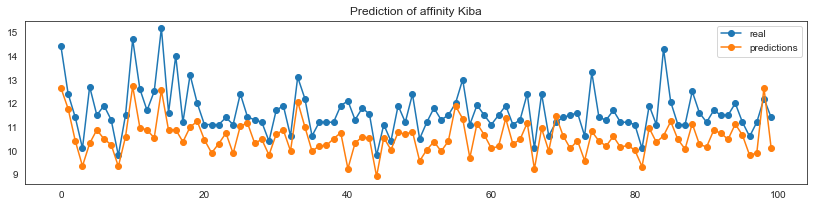

In [53]:
plt.figure(figsize=(14,3))
plt.plot(range(100), te_Y[:100], '-o', label = 'real data')
plt.plot(range(100), predicted_te_Y[:100], '-o', label = 'predictions')
plt.title('Prediction of affinity Kiba')
plt.legend(['real', 'predictions'], loc='upper right')
plt.show();

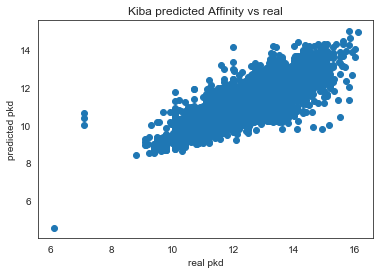

In [54]:
plt.scatter(te_Y, predicted_te_Y)
plt.title('Kiba predicted Affinity vs real')
plt.ylabel('predicted pkd')
plt.xlabel('real pkd')
plt.show()

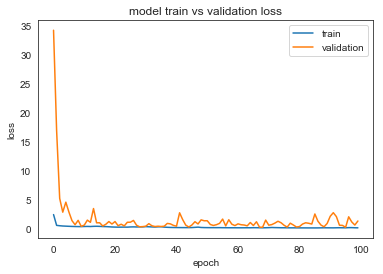

In [55]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

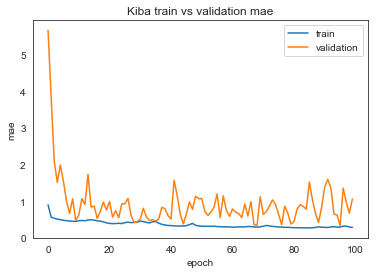

In [56]:
plt.plot(history1.history['mean_absolute_error'])
plt.plot(history1.history['val_mean_absolute_error'])
plt.title('Kiba train vs validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [57]:
pred_davis = Affinity_Model.predict([np.array(tr_drugs),np.array(tr_prots)])

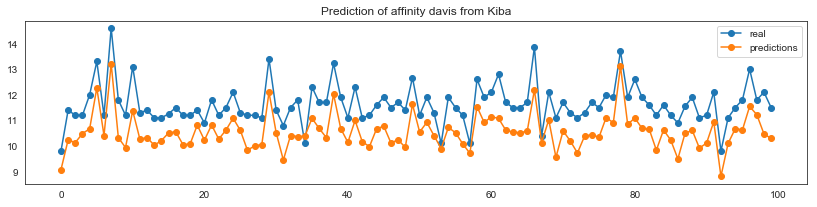

In [58]:
plt.figure(figsize=(14,3))
plt.plot(range(100), tr_Y[:100], '-o', label = 'real data')
plt.plot(range(100), pred_davis[:100], '-o', label = 'predictions')
plt.title('Prediction of affinity davis from Kiba')
plt.legend(['real', 'predictions'], loc='upper right')
plt.show();

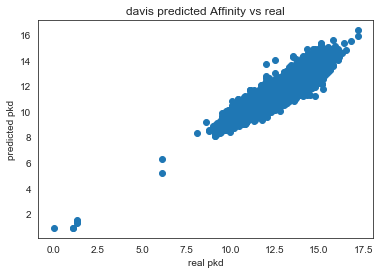

In [59]:
plt.scatter(tr_Y, pred_davis)
plt.title('davis predicted Affinity vs real')
plt.ylabel('predicted pkd')
plt.xlabel('real pkd')
plt.show()

In [64]:
# save model and architecture to single file
Affinity_Model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [65]:
from keras.models import load_model
 # load model
model = load_model('model.h5')
# summarize model.
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 128)     8320        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1000, 128)    3328        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (

In [68]:
# evaluate the model
score = model.evaluate(([np.array(te_drugs),np.array(te_prots) ]), np.array(te_Y), verbose=0)
score

[1.3162640300876831, 1.0609236035126095]

In [3]:
import io